In [1]:
from dask.distributed import Client

client = Client(n_workers=2, threads_per_worker=2, memory_limit="12GB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 22.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57861,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 22.35 GiB
Comm: tcp://127.0.0.1:57873,Total threads: 2
Dashboard: http://127.0.0.1:57876/status,Memory: 11.18 GiB
Nanny: tcp://127.0.0.1:57864,


2025-03-27 03:22:24,745 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:57873 (pid=21372) exceeded 95% memory budget. Restarting...
2025-03-27 03:22:24,755 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:57873' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('repartitiontofewer-11e68300b7bb6ee85bc973bd120d1f67', 0)} (stimulus_id='handle-worker-cleanup-1743031344.7554755')
2025-03-27 03:22:24,758 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-11e68300b7bb6ee85bc973bd120d1f67', 0): 'waiting'}
2025-03-27 03:22:25,932 - distributed.nanny - WARNING - Restarting worker
2025-03-27 03:22:39,343 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:57872 (pid=34568) exceeded 95% memory budget. Restarting...
2025-03-27 03:22:39,353 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:57872' caused the cluster to lose already computed task(s), which will be recomput

In [2]:
ms_file = 'meta_sessions.csv'
ms_attrs_file = 'meta_sessions_attributes.csv'
ms_attrs_definitions = 'meta_sessions_attributes_definitions.csv'

In [3]:
import dask.dataframe as dd
import pandas as pd

In [4]:
ms = dd.read_csv(ms_file)
ms_attrs = dd.read_csv(ms_attrs_file)

In [5]:
with open(ms_attrs_definitions, 'r') as file:
    attrs_indexes = [int(line.split(',')[0].strip('"')) for i, line in enumerate(file) if i > 0]
print(*attrs_indexes, sep=', ')

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28


In [6]:
for idx in attrs_indexes:
    ms_attrs[f'attr_{idx}'] = ms_attrs['value'].where(ms_attrs['session_attribute_definition_id'] == idx, 0)

In [7]:
ms_attrs = ms_attrs.drop(columns=['created_at', 'updated_at', 'session_attribute_definition_id', 'value', 'id'])

In [8]:
full_table = (
    ms_attrs
    .repartition(partition_size='10Mb')
    .merge(
        ms[['id', 'oauth_user_games_id']].repartition(partition_size='10Mb'),
        left_on='session_id',
        right_on='id',
        on='left'
    )
    .drop_duplicates(['session_id'])
)

In [ ]:
full_table.to_csv('result_data.csv', single_file=True, index=False)

In [5]:
full_table = dd.read_csv('result_data.csv')

In [7]:
def shift_group(df):
    df = df.sort_values(by='session_id')
    df['metric'] = df['attr_26'].shift(-1)
    return df

In [8]:
full_table = full_table.groupby('oauth_user_games_id').apply(shift_group, meta={**full_table.dtypes.to_dict(), 'metric': 'int64'})

In [9]:
full_table = full_table.persist()

In [ ]:
full_table.dropna(subset=['metric']).reset_index(drop=True).to_csv('prepared_data.csv', single_file=True, index=False)

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout

In [22]:
full_table = pd.read_csv('prepared_data.csv')

In [44]:
attr_params = [x for x in full_table.columns if x.startswith('attr_')]

In [46]:

X_df = full_table[attr_params]
Y_df = full_table[['metric']]

In [47]:
Y_df.loc[:,'metric'] = (Y_df['metric'] > 0).astype(int)

In [48]:
scaler = StandardScaler()
X = scaler.fit_transform(X_df)
Y = Y_df.values

In [ ]:
_y = Y.ravel()
correlations = np.array([np.corrcoef(X[:, i], _y)[0, 1] for i in range(X.shape[1])])

print(correlations)

C:\Users\andrei_rozdestvenski\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\andrei_rozdestvenski\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[        nan  0.01473394 -0.01046601 -0.00021887 -0.01340097  0.00041092
 -0.00304954 -0.00014794  0.00942839  0.00275514 -0.00335638 -0.00304355
 -0.00104371 -0.00387333 -0.00429289 -0.00317963 -0.00908251 -0.00788377
 -0.00670071 -0.00488505         nan -0.01273213 -0.02142058 -0.0178016
 -0.00134932  0.02639444  0.00148799 -0.01896491]


In [52]:
model = Sequential([
    Input((X.shape[1],)),
    Dense(64, activation='tanh'),
    Dropout(.2),
    Dense(32, activation='tanh'),
    Dropout(.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [53]:
history = model.fit(
    X, Y,
    validation_split=.2,
    epochs=25
)

Epoch 1/25
451754/451754 ━━━━━━━━━━━━━━━━━━━━ 498s 1ms/step - accuracy: 0.7616 - loss: 0.5279 - val_accuracy: 0.7651 - val_loss: 0.5153
Epoch 2/25
451754/451754 ━━━━━━━━━━━━━━━━━━━━ 496s 1ms/step - accuracy: 0.7637 - loss: 0.5193 - val_accuracy: 0.7630 - val_loss: 0.5116
Epoch 3/25
451754/451754 ━━━━━━━━━━━━━━━━━━━━ 490s 1ms/step - accuracy: 0.7658 - loss: 0.5180 - val_accuracy: 0.7692 - val_loss: 0.5126
Epoch 4/25
451754/451754 ━━━━━━━━━━━━━━━━━━━━ 478s 1ms/step - accuracy: 0.7669 - loss: 0.5174 - val_accuracy: 0.7726 - val_loss: 0.5102
Epoch 5/25
451754/451754 ━━━━━━━━━━━━━━━━━━━━ 473s 1ms/step - accuracy: 0.7678 - loss: 0.5166 - val_accuracy: 0.7774 - val_loss: 0.5083
Epoch 6/25
451754/451754 ━━━━━━━━━━━━━━━━━━━━ 473s 1ms/step - accuracy: 0.7683 - loss: 0.5164 - val_accuracy: 0.7727 - val_loss: 0.5095
Epoch 7/25
451754/451754 ━━━━━━━━━━━━━━━━━━━━ 472s 1ms/step - accuracy: 0.7688 - loss: 0.5160 - val_accuracy: 0.7647 - val_loss: 0.5126
Epoch 8/25
451754/451754 ━━━━━━━━━━━━━━━━━━━━ 47

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from matplotlib import pyplot as plt

112939/112939 ━━━━━━━━━━━━━━━━━━━━ 104s 917us/step - accuracy: 0.7750 - loss: 0.5099
Test Accuracy: 0.7753
112939/112939 ━━━━━━━━━━━━━━━━━━━━ 70s 615us/step


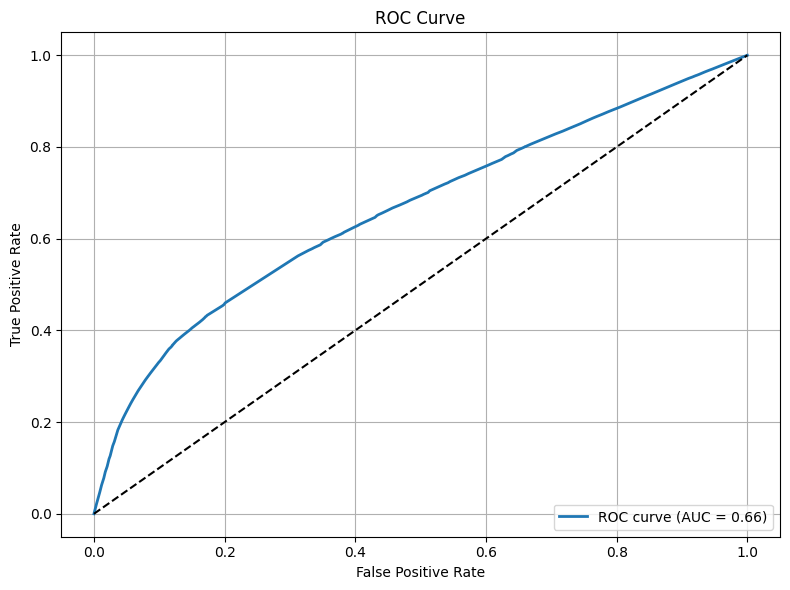

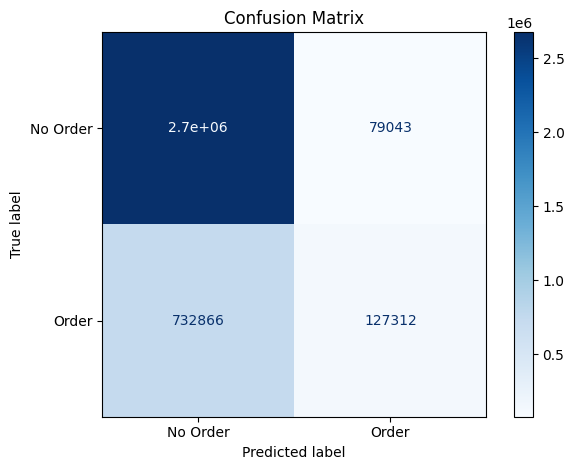

In [58]:
# === 9. Vyhodnotenie modelu ===
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# === 10. Predikcie pravdepodobností pre testovaciu množinu ===
y_probs = model.predict(X_test).ravel()  # .ravel() pre 1D vektor
y_pred = (y_probs > 0.5).astype(int)     # Binarizácia

# === 11. ROC krivka ===
fpr, tpr, thresholds = roc_curve(Y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonála (náhodný model)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 12. Confusion Matrix ===
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Order", "Order"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

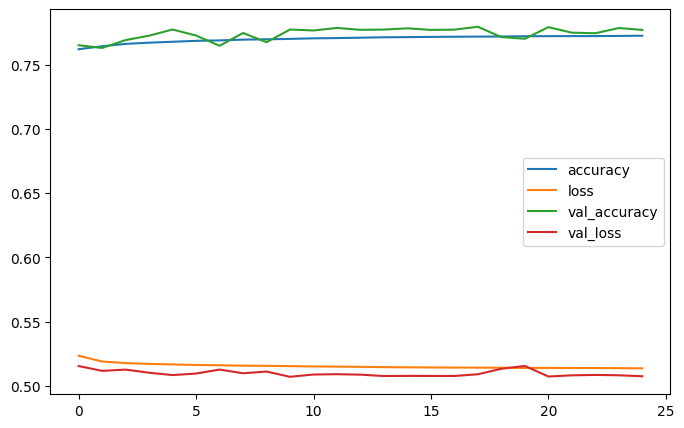

In [59]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [61]:
model.save_weights('./model.weights.h5')